In [1]:
# Written by Carter Archuleta and Owen Fairbairn

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as patches

from cgmbrush.cgmbrush import *

%matplotlib inline

In [2]:
def toPolar(old_field, num_boxes):
    new_field = np.zeros(old_field.shape)

    resolution = len(old_field)
    theta_max = np.arctan(1/(2*num_boxes - 1))
    
    angles = np.zeros(resolution + 1)
    for i in np.arange(0,resolution//2+1,1):
        angles[i] = np.arctan(((resolution//2)-i)/((resolution//2)*(2*num_boxes-1)))
        angles[resolution-i] = -angles[i]
    
    angle_indices = resolution//2 - ((resolution/2) * np.tan(angles))
    new_field_indices = np.arange(0, resolution, 1)
    
    for i in new_field_indices:
        for j in new_field_indices:
            if np.trunc(angle_indices[j]) == np.trunc(angle_indices[j+1]) and np.trunc(angle_indices[i]) == np.trunc(angle_indices[i+1]):
                new_field[i,j] = old_field[int(np.trunc(angle_indices[i])), int(np.trunc(angle_indices[j]))]
            elif np.trunc(angle_indices[j]) == np.trunc(angle_indices[j+1]):
                segment = angle_indices[i+1]-angle_indices[i]
                fraction2 = (angle_indices[i+1]-np.trunc(angle_indices[i+1]))/segment
                fraction1 = 1-fraction2
                new_field[i,j] = fraction1*old_field[int(np.trunc(angle_indices[i])), int(np.trunc(angle_indices[j]))] + fraction2*old_field[int(np.trunc(angle_indices[i+1])), int(np.trunc(angle_indices[j]))]
            elif np.trunc(angle_indices[i]) == np.trunc(angle_indices[i+1]):
                segment = angle_indices[j+1]-angle_indices[j]
                fraction2 = (angle_indices[j+1]-np.trunc(angle_indices[j+1]))/segment
                fraction1 = 1-fraction2
                new_field[i,j] = fraction1*old_field[int(np.trunc(angle_indices[i])), int(np.trunc(angle_indices[j]))] + fraction2*old_field[int(np.trunc(angle_indices[i])), int(np.trunc(angle_indices[j+1]))]
            else:
                segment1 = angle_indices[i+1]-angle_indices[i]
                segment2 = angle_indices[j+1]-angle_indices[j]
                area_tot = segment1*segment2
                
                l1 = angle_indices[i+1]-np.trunc(angle_indices[i+1])
                l2 = np.trunc(angle_indices[i+1])-angle_indices[i]
                l3 = angle_indices[j+1]-np.trunc(angle_indices[j+1])
                l4 = np.trunc(angle_indices[j+1])-angle_indices[j]
                
                area1 = l1*l4
                area2 = l2*l4
                area3 = l1*l3
                area4 = l2*l3
                
                fraction1 = area1/area_tot
                fraction2 = area2/area_tot
                fraction3 = area3/area_tot
                fraction4 = area4/area_tot
                
                val1 = old_field[int(np.trunc(angle_indices[i+1])), int(np.trunc(angle_indices[j]))]
                val2 = old_field[int(np.trunc(angle_indices[i])), int(np.trunc(angle_indices[j]))]
                val3 = old_field[int(np.trunc(angle_indices[i+1])), int(np.trunc(angle_indices[j+1]))]
                val4 = old_field[int(np.trunc(angle_indices[i])), int(np.trunc(angle_indices[j+1]))]
                
                new_field[i,j] = fraction1*val1 + fraction2*val2 + fraction3*val3 + fraction4*val4
                
    return new_field

In [3]:
redshift = 0
N = 2 #Number of boxes
# I don't think the box size is necessary?
L = 20 #Box size

provider = BolshoiProvider()
profile = SphericalTophatProfile()
halos = provider.get_halos(redshift)
df, bins = create_halo_array_for_convolution(halos, 1e12, 1e15, 30)

#--------------------------------------------------------#  ||
# Choose field you want to use and comment the other out #  ||
#--------------------------------------------------------#  \/

#field = provider.get_density_field(0, 256)
field, conv_rad_dT, addition_masks_dT, Tvir_avg = make_halo_dT_map(df, 1, bins, profile, 1, redshift) #Resolution = 1 for speed

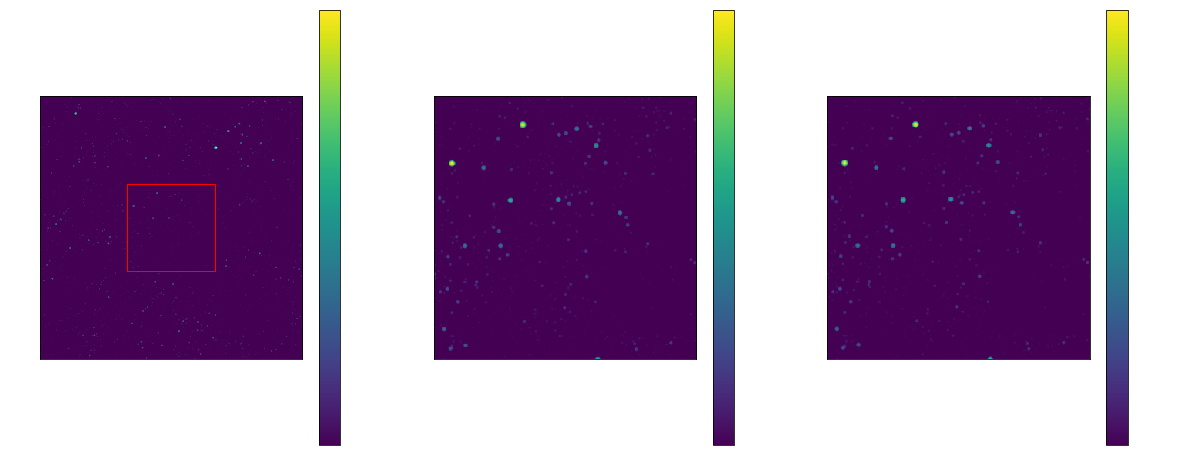

In [5]:
resolution = len(field)

new_field = toPolar(field, N)

x_cut = resolution/2*(1-1/(2*N-1))

zoom_field = field[int(np.trunc(x_cut)):int(np.trunc(resolution-x_cut)), int(np.trunc(x_cut)):int(np.trunc(resolution-x_cut))]

width = int(np.trunc(resolution-x_cut)) - int(np.trunc(x_cut))

fig, ax = plt.subplots(1,3,figsize=(20, 20))

ax[0].set_title('Field')
ax[1].set_title('Zoomed Field')
ax[2].set_title('Co-Moved Field')

plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

pos = ax[0].imshow(field)
fig.colorbar(pos, ax=ax[1], shrink=0.4)
rect = patches.Rectangle((int(np.trunc(x_cut)),int(np.trunc(x_cut))),width,width,linewidth=1,edgecolor='r',facecolor='none')
ax[0].add_patch(rect)
pos = ax[1].imshow(zoom_field)
fig.colorbar(pos, ax=ax[0], shrink=0.4)
pos = ax[2].imshow(new_field)
fig.colorbar(pos, ax=ax[2], shrink=0.4)